In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
plt.style.use('ggplot')

In [219]:
names = ['AEP','COMED','DAYTON','DEOK','DOM','DUQ','EKPC','FE','NI','PJM_Load','PJME','PJMW','est_pjm']
files = []
for name in names:
    temp = pd.read_csv('hourly-energy-consumption/' + name + '_' + 'hourly.csv')
    temp = temp.sort_values(by='Datetime')
    files.append(temp)

In [220]:
for i in range(len(files)):
    files[i].Datetime = pd.to_datetime(files[i].Datetime)
    files[i]['Date'] = files[i].Datetime.apply(lambda x: x.date())
    files[i]['Year'] = files[i].Datetime.apply(lambda x: x.year)
    files[i]['Quarter'] = files[i].Datetime.apply(lambda x: x.quarter)
    files[i]['Month'] = files[i].Datetime.apply(lambda x: x.month)
    files[i]['Week'] = files[i].Datetime.apply(lambda x: x.weekofyear)
    files[i]['DayofYear'] = files[i].Datetime.apply(lambda x: x.dayofyear)
    files[i]['DayofMonth'] = files[i].Datetime.apply(lambda x: x.day)
    files[i]['DayofWeek'] = files[i].Datetime.apply(lambda x: x.weekday()+1)
    files[i]['Hour'] = files[i].Datetime.apply(lambda x: x.hour)

In [222]:
files[8].head()

,Datetime,NI_MW,Date,Year,Quarter,Month,Week,DayofYear,DayofMonth,DayofWeek,Hour
5855,2004-05-01 01:00:00,9198.0,2004-05-01,2004,2,5,18,122,1,6,1
5856,2004-05-01 02:00:00,8570.0,2004-05-01,2004,2,5,18,122,1,6,2
5857,2004-05-01 03:00:00,8183.0,2004-05-01,2004,2,5,18,122,1,6,3
5858,2004-05-01 04:00:00,7917.0,2004-05-01,2004,2,5,18,122,1,6,4
5859,2004-05-01 05:00:00,7828.0,2004-05-01,2004,2,5,18,122,1,6,5


In [4]:
files[0].head()

,Datetime,AEP_MW,Date,Year,Quarter,Month,Week,DayofYear,DayofMonth,DayofWeek,Hour
2183,2004-10-01 01:00:00,12379.0,2004-10-01,2004,4,10,40,275,1,5,1
2184,2004-10-01 02:00:00,11935.0,2004-10-01,2004,4,10,40,275,1,5,2
2185,2004-10-01 03:00:00,11692.0,2004-10-01,2004,4,10,40,275,1,5,3
2186,2004-10-01 04:00:00,11597.0,2004-10-01,2004,4,10,40,275,1,5,4
2187,2004-10-01 05:00:00,11681.0,2004-10-01,2004,4,10,40,275,1,5,5


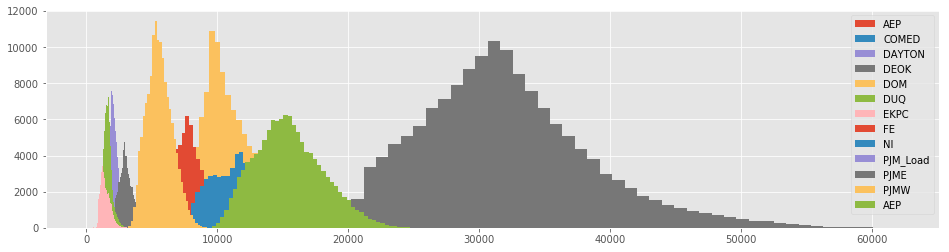

In [352]:
figure(figsize=(16,4))
for file in files:
    file.iloc[:,1].hist(bins=50,label='{}'.format(file.columns[1].split('_MW')[0]))
    plt.legend()

In [345]:
def draw_by(data,by=['Year','Quarter','Month','DayofWeek','Hour']):
   
    Aves = []
    for item in by:
        Aves.append(data.groupby([item]).agg({'{}'.format(data.columns[1]):'mean'}).reset_index())

    fig,ax = plt.subplots(1,len(by),figsize=(20,4))
    for i,ave in enumerate(Aves):
        ax[i].bar(ave.iloc[:,0],ave.iloc[:,1])
        ax[i].set_title('{}:{}'.format(data.columns[1].split('_MW')[0],ave.columns[0]))
    return Aves

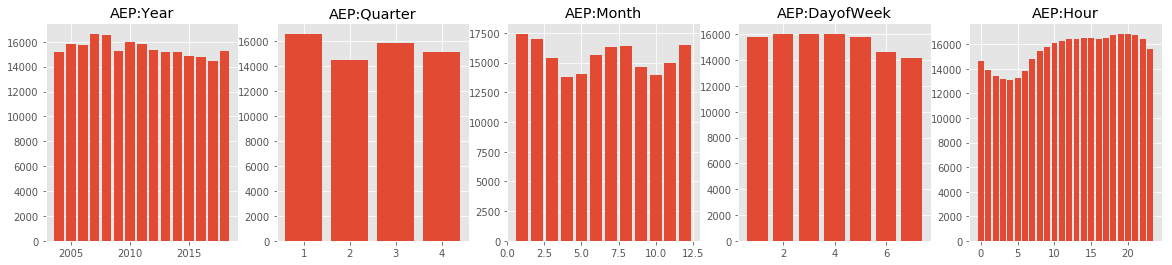

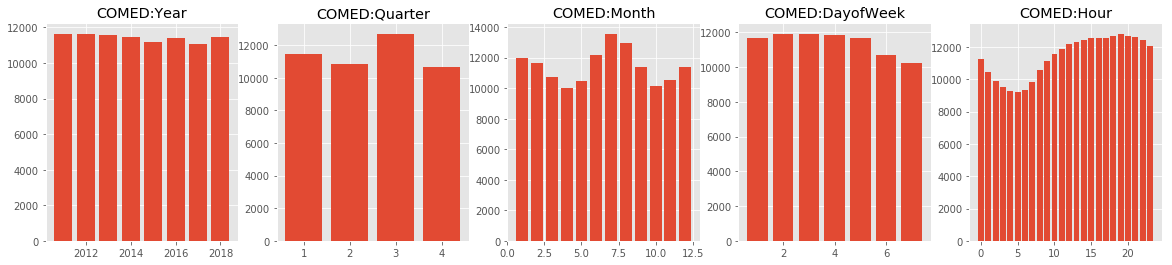

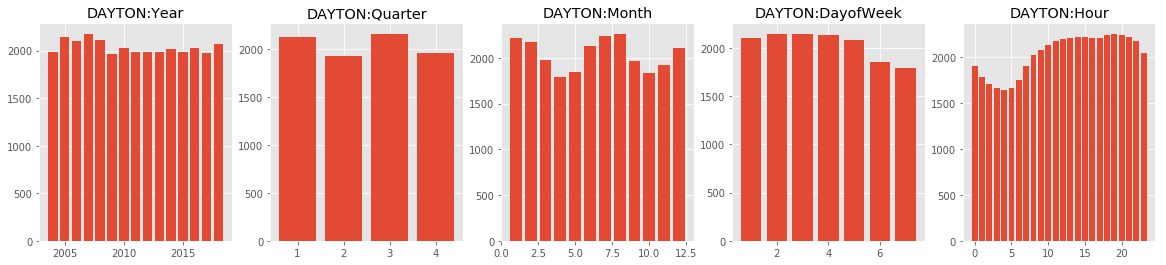

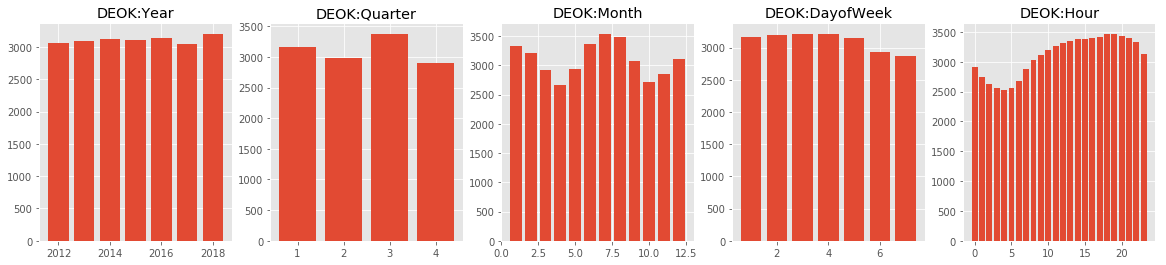

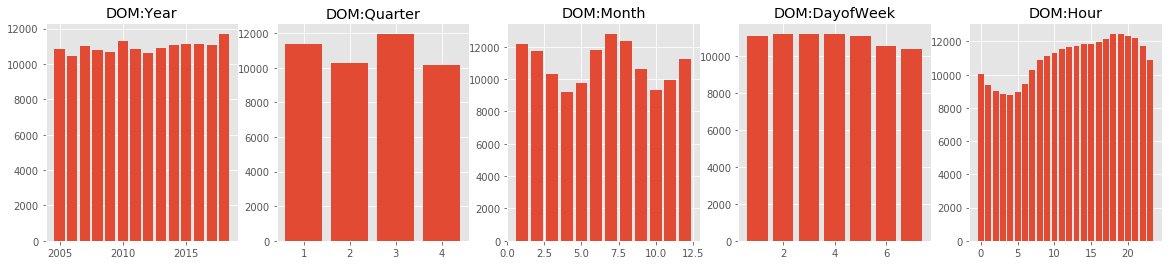

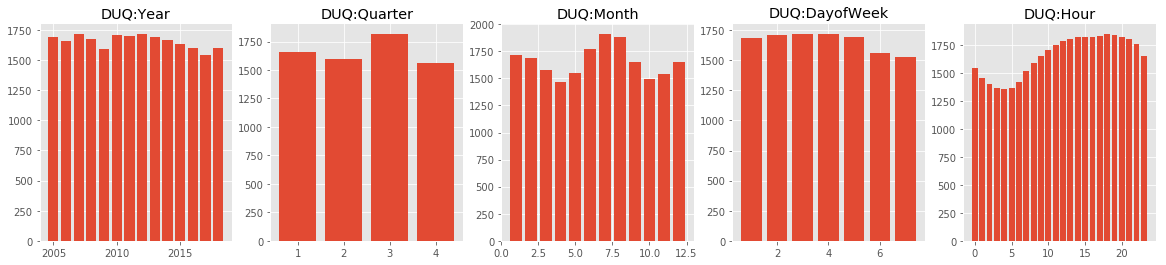

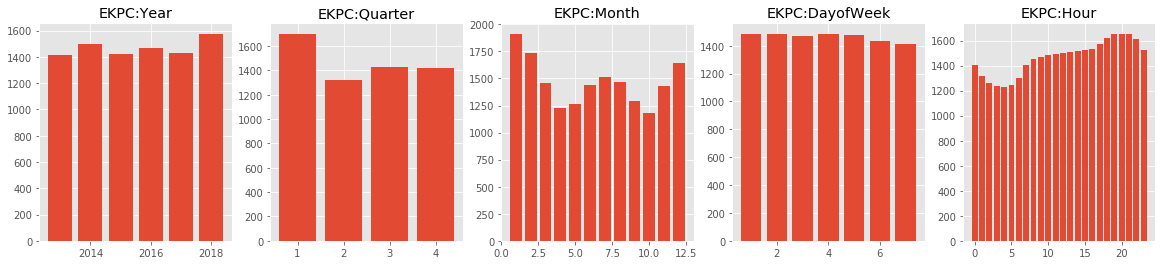

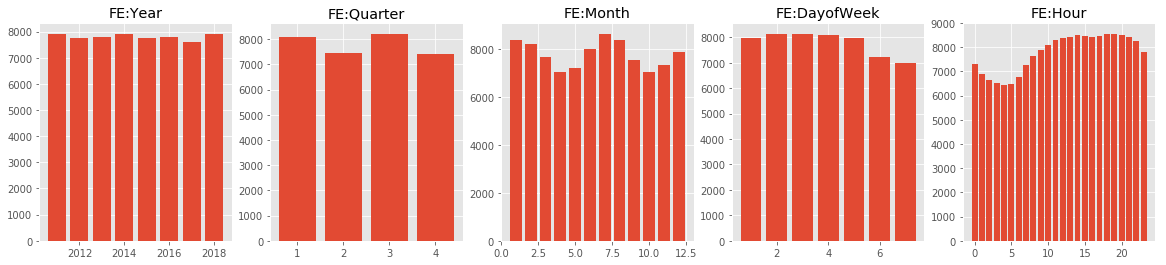

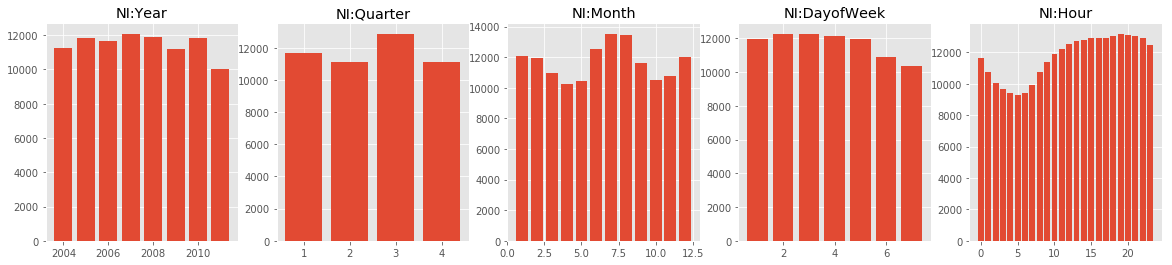

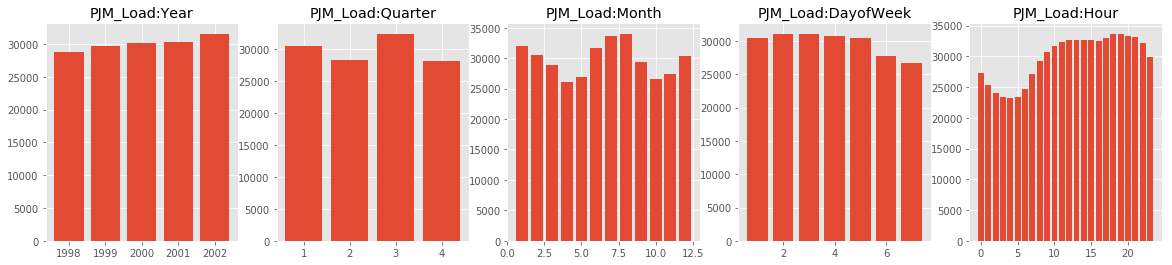

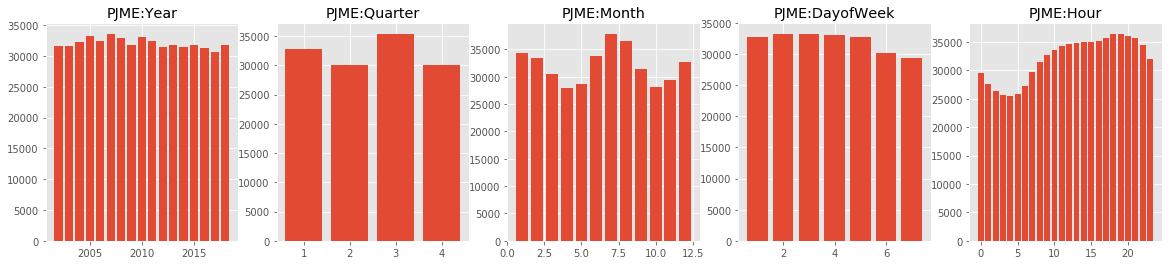

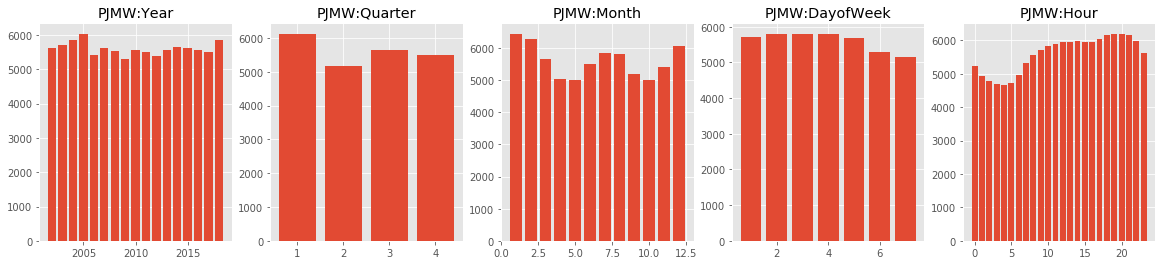

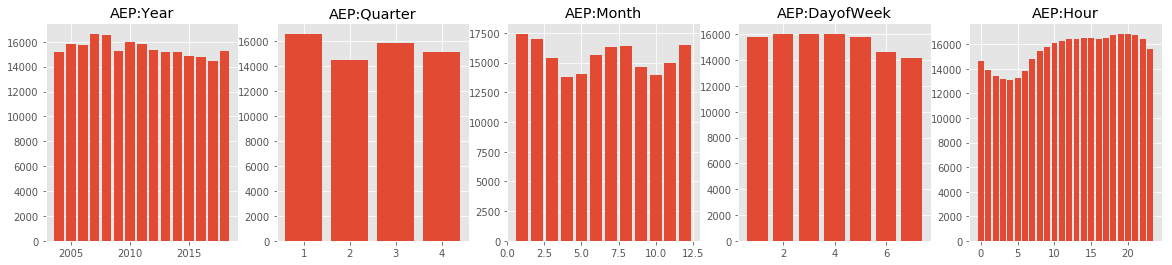

In [347]:
for file in files:
    draw_by(file)

In [240]:
def model_setup(dataset):
    # step 1: train and test split    
    train = dataset[dataset['Year']<max(dataset['Year'])-1]
    test = dataset[dataset['Year']>=max(dataset['Year'])-1]
    train_x = train[['Year','Quarter','Month','Week','DayofYear','DayofMonth','DayofWeek','Hour']]
    train_y = train.iloc[:,1]
    test_x = test[['Year','Quarter','Month','Week','DayofYear','DayofMonth','DayofWeek','Hour']]
    test_y = test.iloc[:,1]
    x_axis = test['Datetime']
    area_name = dataset.columns[1].split('_MW')[0]
    # step 2: use XGBRegressor 
    xgb_r = XGBRegressor(objective='reg:squarederror')
    xgb_r.fit(train_x,train_y)
    pred = xgb_r.predict(test_x)
    
    return xgb_r, train_x, train_y, test_x,test_y, pred, x_axis, area_name

'''/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) ''' 
# don't know how to resolve the above issue
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)    

In [241]:
full = []
for i in range(len(files)-1):
    dic = {}
    dic['model'],dic['train_x'],dic['train_y'],dic['test_x'],dic['test_y'],dic['prediction'],dic['x_axis'],dic['area'] = model_setup(files[i])
    full.append(dic)

In [243]:
for i in range(len(full)):
    rmse = np.sqrt(mean_squared_error(full[i]['test_y'], full[i]['prediction']))
    print("RMSE of the model in area %s: %f" % (full[i]['area'],rmse))

RMSE of the model in area AEP: 1633.012352
RMSE of the model in area COMED: 1387.938649
RMSE of the model in area DAYTON: 230.235167
RMSE of the model in area DEOK: 397.221256
RMSE of the model in area DOM: 1789.474946
RMSE of the model in area DUQ: 181.045995
RMSE of the model in area EKPC: 310.035311
RMSE of the model in area FE: 782.367261
RMSE of the model in area NI: 1502.252559
RMSE of the model in area PJM_Load: 2998.872855
RMSE of the model in area PJME: 3887.528132
RMSE of the model in area PJMW: 690.961606


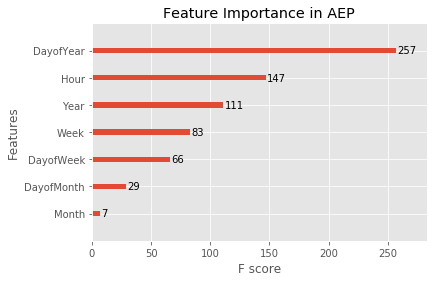

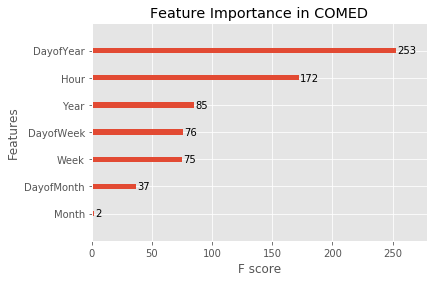

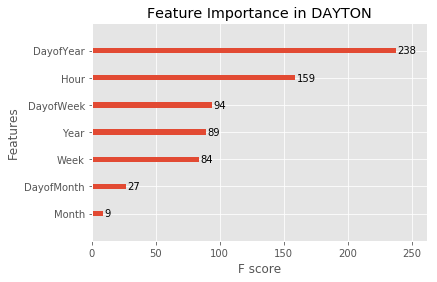

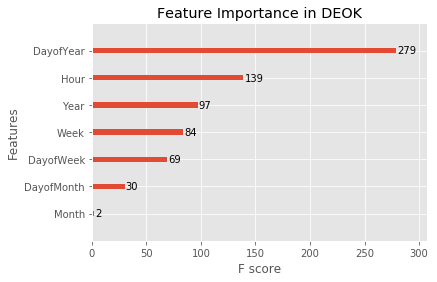

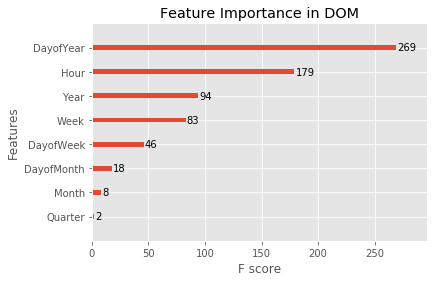

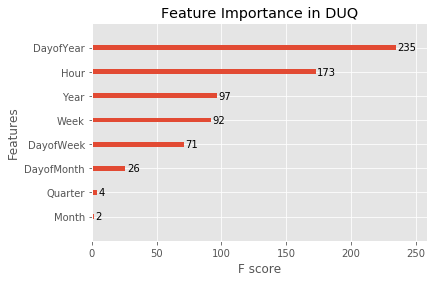

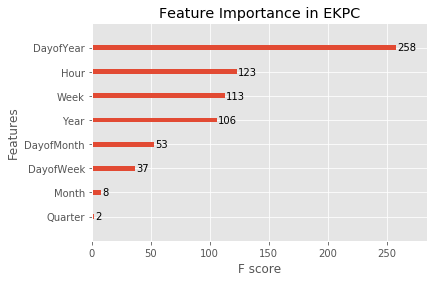

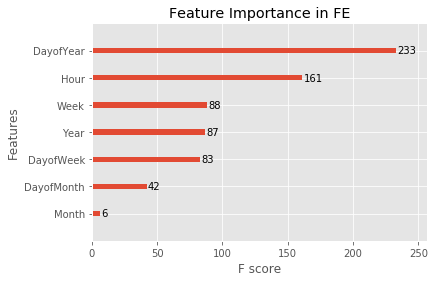

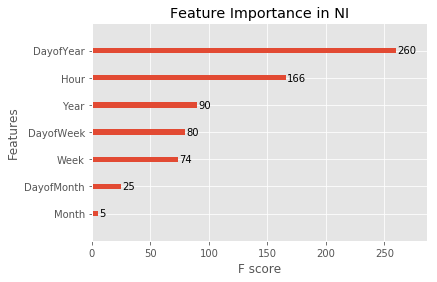

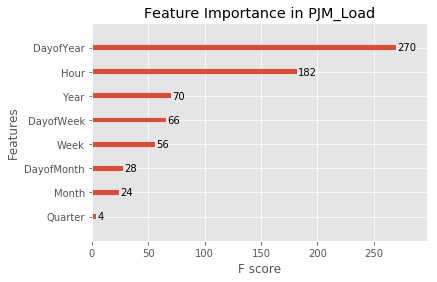

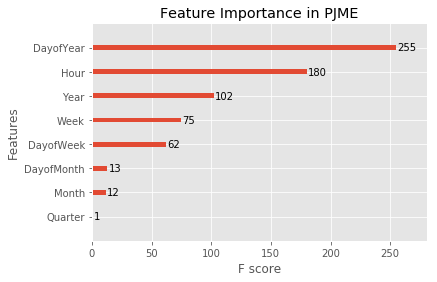

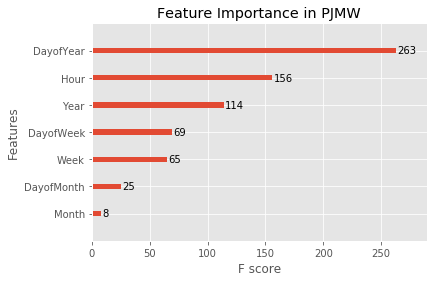

In [350]:
for i in range(len(full)):
    title = 'Feature Importance in {}'.format(full[i]['area'])
    plot_importance(full[i]['model'],title=title)

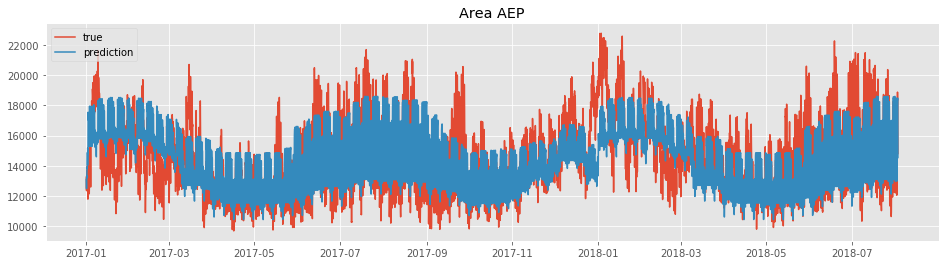

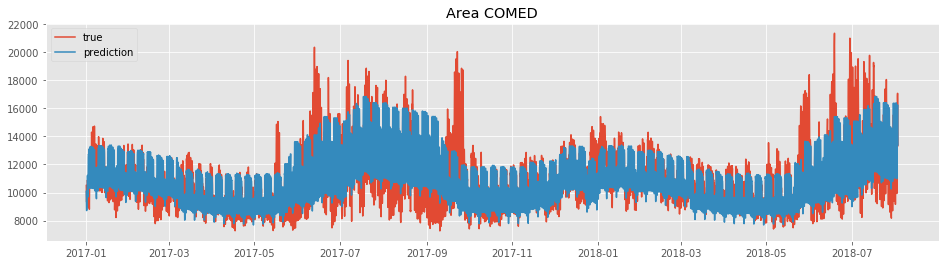

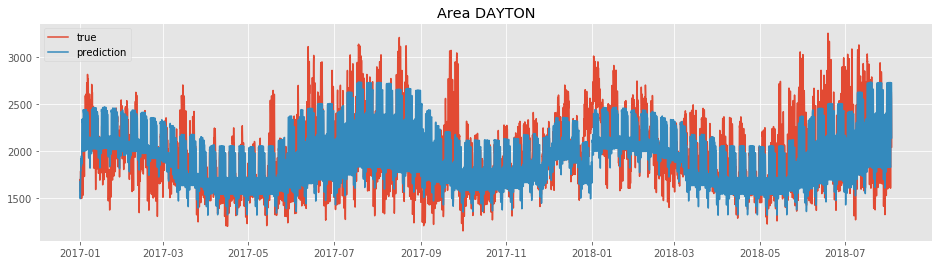

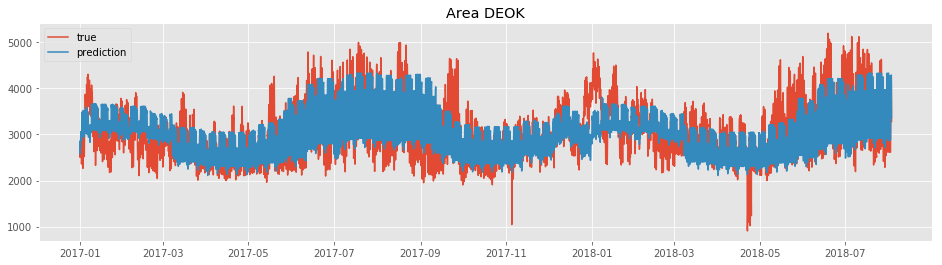

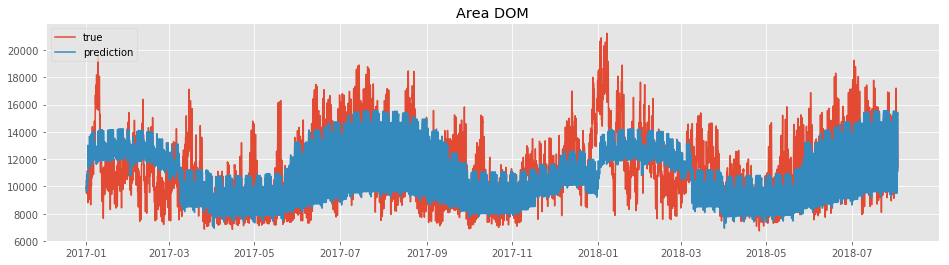

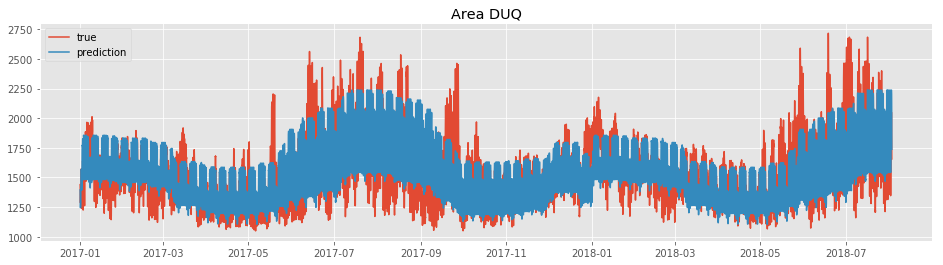

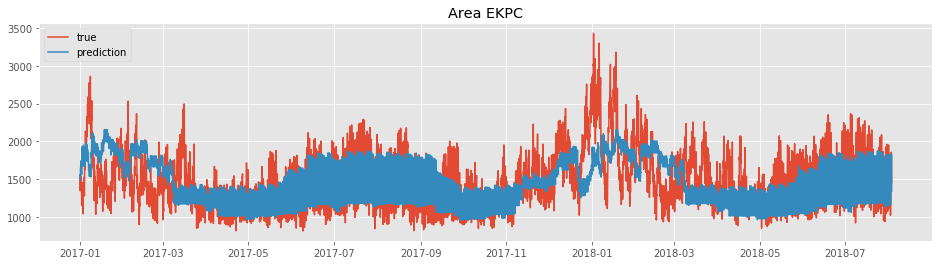

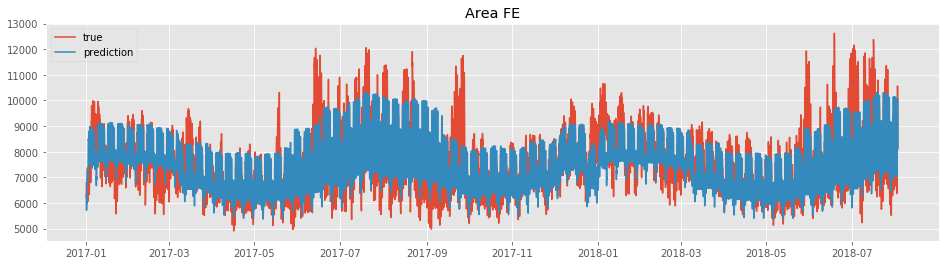

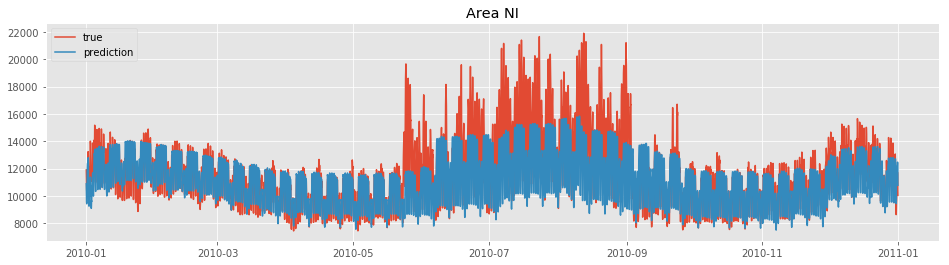

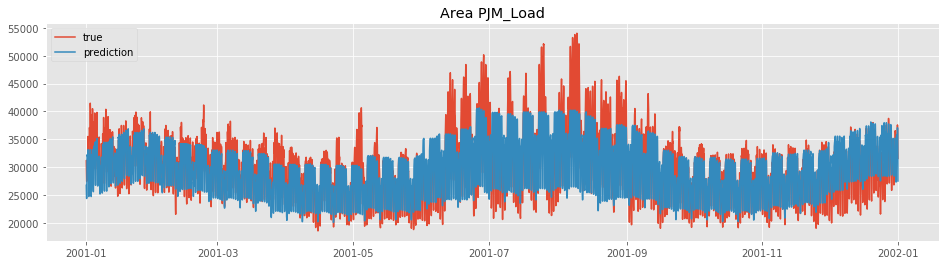

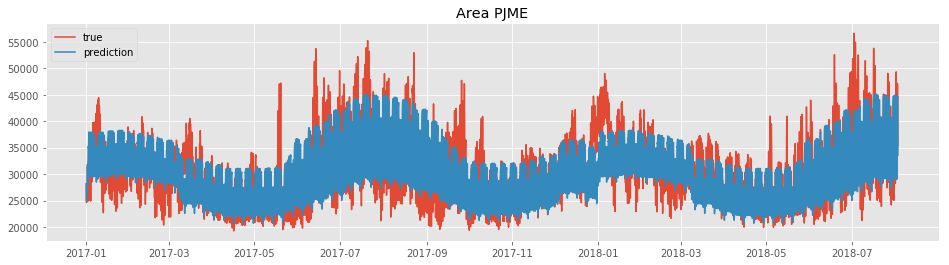

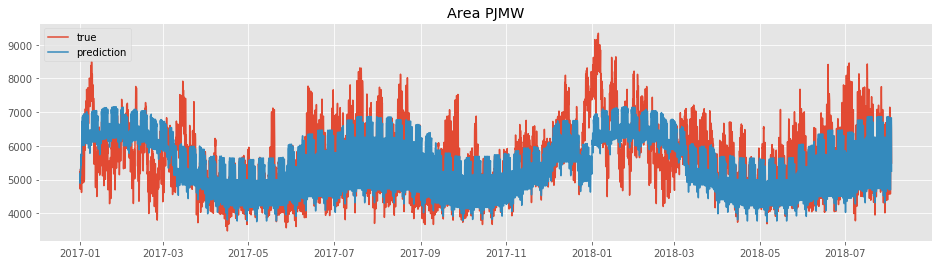

In [247]:
for i in range(len(full)):
    figure(figsize = (16,4))
    plt.plot(full[i]['x_axis'],full[i]['test_y'],label='true')
    plt.plot(full[i]['x_axis'],full[i]['prediction'],label='prediction')
    plt.title('Area {}'.format(full[i]['area']))
    plt.legend(loc='upper left')